# Image Colorization
This project builds a **Convolutional Neural Network (CNN)** that learns to colorize grayscale images by predicting the *a* and *b* color channels in the **Lab color space**, given the *L* (lightness) channel.

## Step 1: Install Required Libraries
Before running the notebook, make sure the following libraries are installed:


*   TensorFlow - for building and training the CNN
*   OpenCV - for image processing
*   NumPy - for numerical operations
*   Pillow (PIL) - for image loading and manipulation
*   Matplotlib - for visualizing results
*   scikit-image - for image utilities

If you do not have them installed, open **Anaconda Prompt** and run:

```bash
conda install -c conda-forge tensorflow matplotlib opencv scikit-image pillow numpy
```

If you are not using Anaconda, you can install packages in the terminal with:

```bash
pip install tensorflow opencv-python matplotlib scikit-image Pillow numpy
```

## Step 2: Import Libraries
In this step, we import all essential libraries needed to build and train the CNN model for image colorization.



*   NumPy (np) - for handling numerical arrays and data manipulation
*   TensorFlow (tf) - for building and training the neural network
*   Keras Layers (Conv2D, UpSampling2D, etc.) - for defining the CNN architecture
*   CIFAR-10 dataset - used here for training and testing (you can replace it with another dataset later)
*   OpenCV (cv2) - for image processing tasks like converting color spaces
*   Matplotlib(plt) - for visualizing images and results





In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import cv2
import matplotlib.pyplot as plt

## Step 3: Load CIFAR-10 Dataset
In this step, we load the **CIFAR-10 dataset**, which contains 60,000 color images (32x32 pixels) across 10 classes.
Since this project focuses on *colorization*, we only need the image data, not the labels.

In [2]:
# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data() # We ignore labels since colorization is unsupervised

# Normalize to 0-255 as uint8 for OpenCV
# 'uint8' is an 8-bit unsigned integer, representing pixel values from 0 to 255
x_train = x_train.astype('uint8')
x_test = x_test.astype('uint8')

# Display dataset shapes
print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

# Store dataset info
num_samples = x_train.shape[0] # Number of training images
num_test = x_test.shape[0] # Number of test images
height, width = x_train.shape[1], x_train.shape[2] # Image dimensions

Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


## Step 4: Convert Images to Lab Color Space
To train our CNN to colorize grayscale images, we convert the RGB images into the Lab color space, which separates **lightness (L)** from **color (a and b)** components.

This allows the model to **learn the color channels (a, b)** while being given only the **lightness channel (L)** as input.

In [3]:
# Initialize arrays for L (input) and ab (output) channels
x_l = np.zeros((num_samples, height, width, 1), dtype=np.float32) # L channel (grayscale)
y_ab = np.zeros((num_samples, height, width, 2), dtype=np.float32) # a and b channels (color)

# Display shapes
print("x_l shape:", x_l.shape)
print("y_ab shape:", y_ab.shape)

# Convert training images from RGB to Lab color space
for i, image in enumerate(x_train):
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB) # Convert from RGB to Lab
    # Normalize L channel to [0, 1]
    x_l[i, ..., 0] = lab_image[:, :, 0].astype(np.float32) / 255.0
    # Normalize a and b channels to approximately [-1, 1]
    y_ab[i] = (lab_image[:, :, 1:].astype(np.float32) - 128) / 128.0

# Display normalization test
print("x_l range:", x_l.min(), "to", x_l.max()) # Expected ~0.0 to 1.0
print("y_ab range:", y_ab.min(), "to", y_ab.max()) # Expected ~1.0 to 1.0

# Initialize test arrays
x_l_test = np.zeros((num_test, height, width, 1), dtype=np.float32)
y_ab_test = np.zeros((num_test, height, width, 2), dtype=np.float32)

print("x_l_test shape:", x_l_test.shape)
print("y_ab_test shape:", y_ab_test.shape)

# Convert test images
for i, image in enumerate(x_test):
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    x_l_test[i, ..., 0] = lab_image[:, :, 0].astype(np.float32) / 255.0
    y_ab_test[i] = (lab_image[:, :, 1:].astype(np.float32) - 128) / 128.0

x_l shape: (50000, 32, 32, 1)
y_ab shape: (50000, 32, 32, 2)
x_l range: 0.0 to 1.0
y_ab range: -0.84375 to 0.765625
x_l_test shape: (10000, 32, 32, 1)
y_ab_test shape: (10000, 32, 32, 2)


## Step 5: Design the CNN Architecture
In this step, we build a *Convolutional Neural Network (CNN)* that takes a grayscale image (*L channel*) as input and predicts the color information (*a and b channels*) in the **Lab color space**.

The model follows an **enconder-decoder** structure:

*   **Encoder**: Extracts features and compresses the input image representation
*   **Decoder**: Reconstructs the color information from the learned features.



In [4]:
# Create input layer
input_layer = Input(shape=(height, width, 1), name='L_input')

# --- Encoder ---
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x) # Downsample
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x) # Bottleneck layer
x = BatchNormalization()(x)

# --- Decoder ---
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# --- Output layer ---
# 2 channels for 'a' and 'b', using tanh activation to keep values in [-1, 1]
output_layer = Conv2D(2, (3, 3), activation='tanh', padding='same')(x)

# Create and compile model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

# Check data ranges
print("x_l range:", x_l.min(), "to", x_l.max()) # Expected ~0-1
print("y_ab range:", y_ab.min(), "to", y_ab.max()) # Expected ~-1 to 1

# Train the model
history = model.fit(
    x_l, y_ab,
    validation_data=(x_l_test, y_ab_test),
    batch_size=64,
    epochs=30,
    shuffle=True
)

x_l range: 0.0 to 1.0
y_ab range: -0.84375 to 0.765625
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - loss: 0.0449 - val_loss: 0.0190
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0123 - val_loss: 0.0131
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0107 - val_loss: 0.0117
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0104 - val_loss: 0.0105
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0099 - val_loss: 0.0145
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0098 - val_loss: 0.0155
Epoch 9/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 10/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0094 - val_loss: 0.0111
Epoch 11/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0

## Step 6: Predict and Visualize Results
After training, we use the model to predict the *a* and *b* color channels from a grayscale test image and convert the Lab output back to RGB.

Test L_input range: 0.11764706 to 0.99607843
LAB output ranges:
L: 11.764706 to 99.60784
A: -4.953199 to 13.463432
B: -14.6888485 to 25.986284


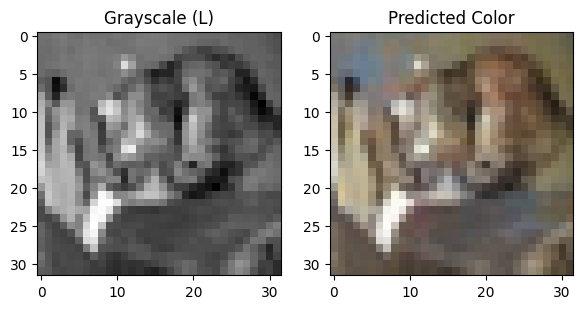

In [5]:
# Select one test image
L_input = x_l_test[0:1] # Shape (1, H, W, 1)
print("Test L_input range:", L_input.min(), "to", L_input.max()) # Should be 0-1

# Predict color channels
ab_pred = model.predict(L_input, verbose=0)[0]
ab_pred = np.clip(ab_pred, -1.0, 1.0)

# Recombine L and predicted ab into a full Lab image
lab_output = np.zeros((height, width, 3), dtype=np.float32)
lab_output[:, :, 0] = L_input[0, :, :, 0] * 100       # Scale back L
lab_output[:, :, 1:] = ab_pred * 128                  # Scale back a/b

print("LAB output ranges:")
print("L:", lab_output[:, :, 0].min(), "to", lab_output[:, :, 0].max())
print("A:", lab_output[:, :, 1].min(), "to", lab_output[:, :, 1].max())
print("B:", lab_output[:, :, 2].min(), "to", lab_output[:, :, 2].max())

# Convert LAB back to RGB
rgb_output = cv2.cvtColor(lab_output, cv2.COLOR_LAB2RGB)
rgb_output = np.clip(rgb_output, 0.0, 1.0)

# Display grayscale vs. predicted colorized image
plt.figure(figsize=(6,3)) # Original grayscale
plt.subplot(1,2,1)
plt.imshow(L_input[0,:,:,0], cmap='gray')
plt.title("Grayscale (L)")

plt.subplot(1,2,2)
plt.imshow(rgb_output)
plt.title("Predicted Color")

plt.tight_layout()
plt.show()

## Step 7: Visualize More Predictions
Now that the model is trained, let's visualize how well it performs on several test images. We'll compare each original **grayscale (L)** input with its **predicted colorized output** generated by the model.

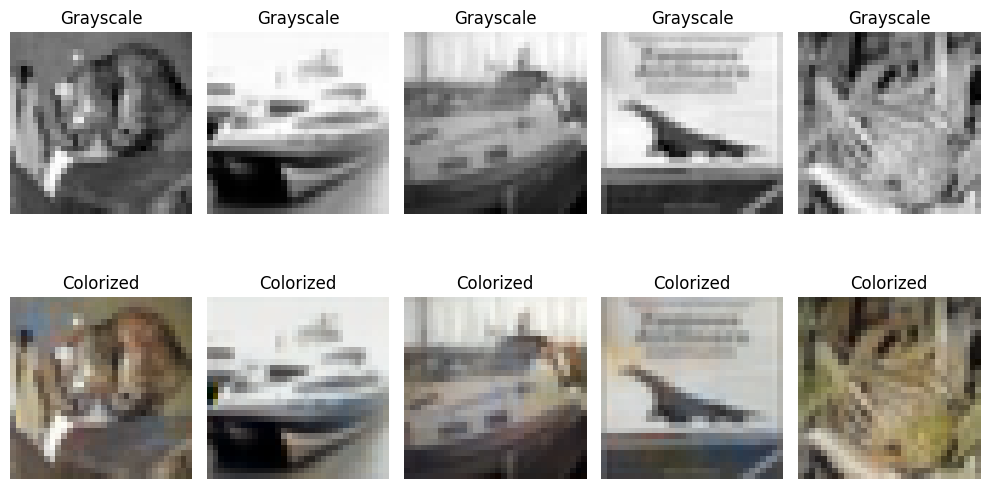

In [6]:
num_show = 5 # Number of images to display
plt.figure(figsize=(10, 6))

for i in range(num_show):
  # Select one test image
  L_input = x_l_test[i:i + 1] # Shape: (1, H, W, 1)

  # Predict a and b color channels
  ab_pred = model.predict(L_input, verbose=0)[0]

  # Recombine L and predicted ab channels into a Lab image
  lab_output = np.zeros((height, width, 3), dtype=np.float32)
  lab_output[:, :, 0] = L_input[0, :, :, 0] * 100   # Scale L back
  lab_output[:, :, 1:] = ab_pred * 128              # Scale ab back

  # Convert from Lab to RGB
  rgb_output = cv2.cvtColor(lab_output, cv2.COLOR_LAB2RGB)
  rgb_output = np.clip(rgb_output, 0.0, 1.0)

  # Plot grayscale image
  plt.subplot(2, num_show, i + 1)
  plt.imshow(L_input[0, :, :, 0], cmap='gray')
  plt.axis('off')
  plt.title('Grayscale')

  # Plot colorized output
  plt.subplot(2, num_show, num_show + i + 1)
  plt.imshow(rgb_output)
  plt.axis('off')
  plt.title('Colorized')

plt.tight_layout()
plt.show()

## Step 8: Evaluate Model Performance
To understand how well the CNN trained, we can visualize the **training and validation loss** over all epochs.
This helps identify whether the model is learning effectively, overfitting, or underfitting.

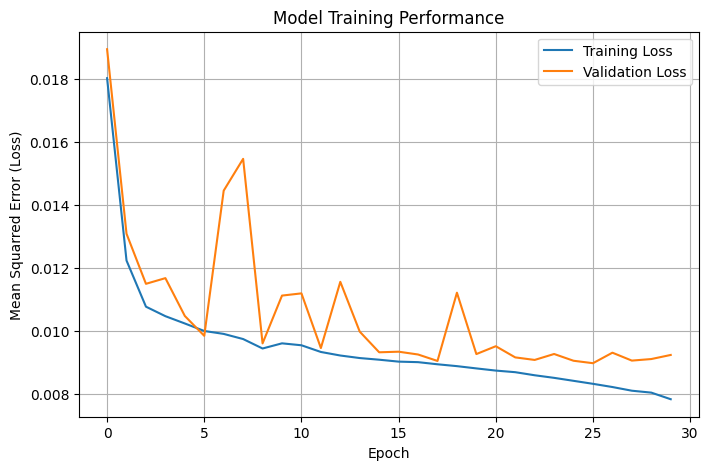

In [7]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Performance')
plt.xlabel('Epoch')
plt.ylabel('Mean Squarred Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()

## Step 9: Save the Model

In [8]:
# Save the entire model
model.save('colorization_model.h5')
print("Model saved successfully!")

Model saved successfully!
